# step-by-step node2vec implementation using only:

* **NetworkX** → graph representation
* **NumPy** → numeric helpers
* **PyTorch** → embeddings + training (Skip-gram + negative sampling)

In [1]:
import random
from collections import defaultdict
from typing import List, Dict, Tuple

import numpy as np
import networkx as nx
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
########################################
# 1. Alias sampling (O(1) discrete sampling)
########################################

def alias_setup(probs: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Construct alias tables for a discrete distribution.

    Args:
        probs: 1D array of probabilities (sum to 1).

    Returns:
        J, q: alias index array and probability array.
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int64)

    # Scaled probabilities
    scaled_probs = probs * K

    # Worklists of small and large
    small = []
    large = []
    for idx, prob in enumerate(scaled_probs):
        if prob < 1.0:
            small.append(idx)
        else:
            large.append(idx)

    # Construct the alias table
    while small and large:
        s = small.pop()
        l = large.pop()

        q[s] = scaled_probs[s]
        J[s] = l

        scaled_probs[l] = scaled_probs[l] - (1.0 - scaled_probs[s])
        if scaled_probs[l] < 1.0:
            small.append(l)
        else:
            large.append(l)

    # Whatever is left has prob 1
    for idx in large + small:
        q[idx] = 1.0
        J[idx] = idx

    return J, q

In [3]:
def alias_draw(J: np.ndarray, q: np.ndarray) -> int:
    """
    Draw a sample from a distribution given its alias tables.
    Returns an index in [0, len(J)-1].
    """
    K = len(J)
    # Step 1: draw a column
    k = int(np.floor(np.random.rand() * K))
    # Step 2: use biased coin
    if np.random.rand() < q[k]:
        return k
    else:
        return J[k]

In [4]:
########################################
# 2. Node2Vec random walker
########################################

class Node2VecWalker:
    """
    Implements the biased 2nd-order random walks used by node2vec.
    """

    def __init__(
        self,
        graph: nx.Graph,
        p: float = 1.0,
        q: float = 1.0,
    ):
        self.G = graph
        self.p = p
        self.q = q

        # Precompute alias tables for:
        # 1) first step from each node (unconditioned)
        # 2) second-order transitions for each directed edge (t -> v)
        self.alias_nodes: Dict[int, Tuple[np.ndarray, np.ndarray]] = {}
        self.alias_edges: Dict[Tuple[int, int], Tuple[np.ndarray, np.ndarray]] = {}

        print("Precomputing transition probabilities...")
        self._preprocess_transition_probs()
        print("Done precomputing transitions.\n")

    def _get_edge_weight(self, u: int, v: int) -> float:
        # Default to 1.0 if no explicit 'weight'
        return self.G[u][v].get("weight", 1.0)

    def _preprocess_transition_probs(self):
        # 2.1 Alias tables for nodes (first step)
        for node in self.G.nodes():
            neighbors = list(self.G.neighbors(node))
            if len(neighbors) == 0:
                continue
            weights = np.array([self._get_edge_weight(node, nbr) for nbr in neighbors], dtype=np.float64)
            probs = weights / weights.sum()
            self.alias_nodes[node] = alias_setup(probs)

        # 2.2 Alias tables for edges (second-order transitions)
        # For each edge (t, v), build the distribution over neighbors of v
        for edge in self.G.edges():
            u, v = edge
            self._get_alias_edge(u, v)
            self._get_alias_edge(v, u)

    def _get_alias_edge(self, t: int, v: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Build alias table for a 2nd-order transition:
            just moved from t -> v, now choose next node x from N(v)
        """
        if (t, v) in self.alias_edges:
            return self.alias_edges[(t, v)]

        neighbors = list(self.G.neighbors(v))
        if len(neighbors) == 0:
            # No neighbors; shouldn't really happen in a connected graph
            probs = np.ones(1)  # dummy
            self.alias_edges[(t, v)] = alias_setup(probs)
            return self.alias_edges[(t, v)]

        unnormalized = []
        for x in neighbors:
            w_vx = self._get_edge_weight(v, x)

            # Distance between t and x: 0 (backtrack), 1 (adjacent), else 2
            if x == t:
                # d(t, x) = 0
                bias = 1.0 / self.p
            elif self.G.has_edge(x, t):
                # d(t, x) = 1
                bias = 1.0
            else:
                # d(t, x) = 2
                bias = 1.0 / self.q

            unnormalized.append(w_vx * bias)

        unnormalized = np.array(unnormalized, dtype=np.float64)
        probs = unnormalized / unnormalized.sum()
        J, q = alias_setup(probs)
        self.alias_edges[(t, v)] = (J, q)
        return J, q

    def simulate_walk(self, start_node: int, walk_length: int) -> List[int]:
        """
        Simulate a single biased random walk starting from start_node.
        """
        walk = [start_node]

        # If no neighbors, just return the node itself repeatedly
        if len(list(self.G.neighbors(start_node))) == 0:
            return walk

        while len(walk) < walk_length:
            curr = walk[-1]
            neighbors = list(self.G.neighbors(curr))
            if len(neighbors) == 0:
                break

            if len(walk) == 1:
                # First step: use node-level alias table
                J, q = self.alias_nodes[curr]
                idx = alias_draw(J, q)
                next_node = neighbors[idx]
            else:
                # 2nd-order step: use edge-level alias table
                prev = walk[-2]
                J, q = self.alias_edges[(prev, curr)]
                next_idx = alias_draw(J, q)
                next_node = neighbors[next_idx]

            walk.append(next_node)

        return walk

    def simulate_walks(self, num_walks_per_node: int, walk_length: int) -> List[List[int]]:
        """
        Simulate random walks starting from each node.

        Returns:
            List of walks, each a list of node ids (as in the original graph).
        """
        nodes = list(self.G.nodes())
        walks = []
        print("Starting random walks...")
        for _ in range(num_walks_per_node):
            random.shuffle(nodes)  # randomize starting order
            for node in nodes:
                w = self.simulate_walk(node, walk_length)
                walks.append(w)
        print(f"Generated {len(walks)} walks.")
        return walks

In [5]:
########################################
# 3. Skip-gram with negative sampling (PyTorch)
########################################

class Node2VecModel(nn.Module):
    """
    Simple Skip-gram model with negative sampling for node2vec.
    """

    def __init__(self, num_nodes: int, embedding_dim: int):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim

        # "Input" embeddings (f(u))
        self.node_emb = nn.Embedding(num_nodes, embedding_dim)
        # "Output" embeddings for context nodes
        self.context_emb = nn.Embedding(num_nodes, embedding_dim)

        # Initialize
        nn.init.xavier_uniform_(self.node_emb.weight)
        nn.init.xavier_uniform_(self.context_emb.weight)

    def forward(self, center_nodes, pos_context, neg_context):
        """
        center_nodes: LongTensor [B]
        pos_context:  LongTensor [B]
        neg_context:  LongTensor [B, K]

        Returns:
            loss: scalar tensor
        """
        # Embeddings
        v_c = self.node_emb(center_nodes)          # [B, D]
        v_pos = self.context_emb(pos_context)      # [B, D]
        v_neg = self.context_emb(neg_context)      # [B, K, D]

        # Positive score: dot product v_c · v_pos (per pair)
        pos_score = torch.sum(v_c * v_pos, dim=1)  # [B]
        # Negative score: v_c · v_neg for each negative sample
        # Expand center to [B, K, D]
        v_c_expanded = v_c.unsqueeze(1)            # [B, 1, D]
        neg_score = torch.sum(v_c_expanded * v_neg, dim=2)  # [B, K]

        # Loss: - (log σ(pos) + Σ log σ(−neg))
        log_pos = torch.log(torch.sigmoid(pos_score) + 1e-15)
        log_neg = torch.log(torch.sigmoid(-neg_score) + 1e-15).sum(dim=1)

        loss = - (log_pos + log_neg).mean()
        return loss

    def get_embeddings(self) -> np.ndarray:
        """
        Returns the learned node embeddings as a NumPy array of shape [num_nodes, embedding_dim].
        """
        return self.node_emb.weight.detach().cpu().numpy()

In [6]:
########################################
# 4. Utility: Build training pairs from walks
########################################

def build_skipgram_pairs(
    walks: List[List[int]],
    node2idx: Dict[int, int],
    window_size: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given random walks (list of node ids), build (center, context) pairs.

    Returns:
        centers: np.array of shape [N_pairs]
        contexts: np.array of shape [N_pairs]
    """
    centers = []
    contexts = []

    for walk in walks:
        mapped = [node2idx[n] for n in walk]
        for i, center in enumerate(mapped):
            # context window [i - window, i + window], skipping i
            start = max(0, i - window_size)
            end = min(len(mapped), i + window_size + 1)
            for j in range(start, end):
                if j == i:
                    continue
                centers.append(center)
                contexts.append(mapped[j])

    centers = np.array(centers, dtype=np.int64)
    contexts = np.array(contexts, dtype=np.int64)
    print(f"Built {len(centers)} (center, context) pairs.")
    return centers, contexts

In [7]:
########################################
# 5. Negative sampler
########################################

class NegativeSampler:
    """
    Draw negative node ids according to a noise distribution,
    e.g. degree^(0.75) or uniform.
    """

    def __init__(self, num_nodes: int, node_freq: np.ndarray = None, power: float = 0.75):
        """
        Args:
            num_nodes: total number of nodes
            node_freq: array of length num_nodes with frequencies (e.g. degree counts),
                       if None -> uniform.
            power: exponent to use on frequencies (word2vec uses 0.75)
        """
        self.num_nodes = num_nodes

        if node_freq is None:
            probs = np.ones(num_nodes) / num_nodes
        else:
            probs = np.power(node_freq, power)
            probs = probs / probs.sum()

        self.J, self.q = alias_setup(probs)

    def sample(self, num_samples: int) -> np.ndarray:
        """
        Sample `num_samples` negative node indices.
        """
        out = np.zeros(num_samples, dtype=np.int64)
        for i in range(num_samples):
            out[i] = alias_draw(self.J, self.q)
        return out

In [8]:
########################################
# 6. Training wrapper
########################################

def train_node2vec(
    G: nx.Graph,
    embedding_dim: int = 128,
    walk_length: int = 80,
    num_walks_per_node: int = 10,
    window_size: int = 10,
    p: float = 1.0,
    q: float = 1.0,
    num_negative: int = 5,
    batch_size: int = 256,
    epochs: int = 5,
    lr: float = 0.025,
    device: str = "cpu",
) -> Tuple[Node2VecModel, Dict[int, int]]:
    """
    End-to-end training of node2vec on a NetworkX graph.

    Returns:
        model: trained Node2VecModel
        node2idx: mapping from original node id to index [0, num_nodes)
    """
    device = torch.device(device)

    # Map nodes to indices [0, N)
    nodes = list(G.nodes())
    node2idx = {n: i for i, n in enumerate(nodes)}
    idx2node = {i: n for n, i in node2idx.items()}
    num_nodes = len(nodes)
    print(f"Graph has {num_nodes} nodes and {G.number_of_edges()} edges.")

    # 1) Random walks
    walker = Node2VecWalker(G, p=p, q=q)
    walks = walker.simulate_walks(num_walks_per_node=num_walks_per_node,
                                  walk_length=walk_length)

    # 2) Build (center, context) pairs for Skip-gram
    centers, contexts = build_skipgram_pairs(walks, node2idx, window_size)

    # 3) Node frequency (for negative sampling): approximate by degree
    degrees = np.zeros(num_nodes, dtype=np.float64)
    for n in G.nodes():
        idx = node2idx[n]
        degrees[idx] = G.degree(n)

    neg_sampler = NegativeSampler(num_nodes, node_freq=degrees, power=0.75)

    # 4) Prepare PyTorch dataset
    centers_t = torch.from_numpy(centers).long()
    contexts_t = torch.from_numpy(contexts).long()
    dataset = TensorDataset(centers_t, contexts_t)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 5) Model & optimizer
    model = Node2VecModel(num_nodes=num_nodes, embedding_dim=embedding_dim).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # 6) Training loop
    print("Starting training...")
    for epoch in range(epochs):
        total_loss = 0.0
        for batch_centers, batch_contexts in dataloader:
            batch_centers = batch_centers.to(device)
            batch_contexts = batch_contexts.to(device)

            # Sample negatives: shape [B, K]
            B = batch_centers.size(0)
            neg_samples = []
            for _ in range(num_negative):
                neg = neg_sampler.sample(B)  # [B]
                neg_samples.append(torch.from_numpy(neg).long())
            neg_samples = torch.stack(neg_samples, dim=1).to(device)  # [B, K]

            optimizer.zero_grad()
            loss = model(batch_centers, batch_contexts, neg_samples)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * B

        avg_loss = total_loss / len(dataset)
        print(f"Epoch {epoch + 1}/{epochs} - loss: {avg_loss:.4f}")
    print("Training finished.\n")

    return model, node2idx

In [9]:
# Small demo graph: karate club
G = nx.karate_club_graph()

model, node2idx = train_node2vec(
    G,
    embedding_dim=64,
    walk_length=20,
    num_walks_per_node=10,
    window_size=5,
    p=1.0,
    q=1.0,
    num_negative=5,
    batch_size=128,
    epochs=5,
    lr=0.025,
    device="cpu",
)

Graph has 34 nodes and 78 edges.
Precomputing transition probabilities...
Done precomputing transitions.

Starting random walks...
Generated 340 walks.
Built 57800 (center, context) pairs.
Starting training...
Epoch 1/5 - loss: 4.0502
Epoch 2/5 - loss: 3.6314
Epoch 3/5 - loss: 3.1661
Epoch 4/5 - loss: 2.8935
Epoch 5/5 - loss: 2.7465
Training finished.



In [10]:
# Get final embeddings (NumPy array: [num_nodes, embedding_dim])
embeddings = model.get_embeddings()
print("Embeddings shape:", embeddings.shape)
# Example: embedding for node 0 in the original graph:
idx = node2idx[0]
print("Embedding for node 0 (first 5 dims):", embeddings[idx][:5])

Embeddings shape: (34, 64)
Embedding for node 0 (first 5 dims): [-0.15502562  0.1282503  -0.29114822  0.01212144 -0.12568973]


---

## 2. How the code maps to the algorithm steps

* **Alias sampling (`alias_setup`, `alias_draw`)**
  → lets each random-walk step be **O(1)**, as described in the paper.

* **`Node2VecWalker`**

  * `_preprocess_transition_probs` → precomputes node-level and edge-level alias tables using **p** and **q**.
  * `simulate_walk` → implements the **2nd-order biased random walk**.
  * `simulate_walks` → runs **r** walks per node, each of length **l**.

* **`build_skipgram_pairs`**
  → converts random walks into (center, context) pairs, like word2vec.

* **`Node2VecModel`**

  * Implements **Skip-gram with negative sampling**:

    * Input embeddings: `node_emb`
    * Output embeddings: `context_emb`
    * Loss: `- [log σ(u·v_pos) + Σ log σ(-u·v_neg)]`

* **`NegativeSampler`**

  * Uses **degree^0.75** distribution to draw negative nodes, like word2vec.

* **`train_node2vec`**

  * Glues everything together:

    1. Preprocess + walks
    2. Training pairs
    3. Negative sampler
    4. Training loop in PyTorch

---


---

## 1. Train two models: BFS-like vs DFS-like

* **BFS-like** → `q > 1` (stay near start, local neighborhoods, role-ish)
* **DFS-like** → `q < 1` (explore far, more community-ish)

In [11]:
# --- BFS-like (q > 1) ---
model_bfs, node2idx_bfs = train_node2vec(
    G,
    embedding_dim=64,
    walk_length=20,
    num_walks_per_node=10,
    window_size=5,
    p=1.0,
    q=2.0,          # BFS-like
    num_negative=5,
    batch_size=128,
    epochs=5,
    lr=0.025,
    device="cpu",
)

# --- DFS-like (q < 1) ---
model_dfs, node2idx_dfs = train_node2vec(
    G,
    embedding_dim=64,
    walk_length=20,
    num_walks_per_node=10,
    window_size=5,
    p=1.0,
    q=0.25,        # DFS-like
    num_negative=5,
    batch_size=128,
    epochs=5,
    lr=0.025,
    device="cpu",
)

Graph has 34 nodes and 78 edges.
Precomputing transition probabilities...
Done precomputing transitions.

Starting random walks...
Generated 340 walks.
Built 57800 (center, context) pairs.
Starting training...
Epoch 1/5 - loss: 4.0608
Epoch 2/5 - loss: 3.6476
Epoch 3/5 - loss: 3.1839
Epoch 4/5 - loss: 2.8840
Epoch 5/5 - loss: 2.7115
Training finished.

Graph has 34 nodes and 78 edges.
Precomputing transition probabilities...
Done precomputing transitions.

Starting random walks...
Generated 340 walks.
Built 57800 (center, context) pairs.
Starting training...
Epoch 1/5 - loss: 4.0304
Epoch 2/5 - loss: 3.6026
Epoch 3/5 - loss: 3.1465
Epoch 4/5 - loss: 2.8867
Epoch 5/5 - loss: 2.7554
Training finished.



## 2. Build a color map for communities / roles

Karate club nodes have attribute `"club"`: `"Mr. Hi"` or `"Officer"`.
We’ll map them to colors.

In [12]:
import numpy as np

nodes = list(G.nodes())

# Get labels per node
club_labels = []
for n in nodes:
    club = G.nodes[n]["club"]  # 'Mr. Hi' or 'Officer'
    club_labels.append(0 if club == "Mr. Hi" else 1)
club_labels = np.array(club_labels)

If you want to color by **degree** or something else structural instead:

```python
degrees = np.array([G.degree(n) for n in nodes])
# You could then use degrees as a continuous color variable.
```

## 3. Get embeddings and project to 2D (PCA)

You can try **PCA** (it’s fast and deterministic).

In [13]:
from sklearn.decomposition import PCA

# Get embeddings in the same node order for both models
emb_bfs = []
emb_dfs = []
for n in nodes:
    idx_bfs = node2idx_bfs[n]
    idx_dfs = node2idx_dfs[n]
    emb_bfs.append(model_bfs.get_embeddings()[idx_bfs])
    emb_dfs.append(model_dfs.get_embeddings()[idx_dfs])

emb_bfs = np.vstack(emb_bfs)  # [N, D]
emb_dfs = np.vstack(emb_dfs)  # [N, D]

# Fit PCA on concatenated space so axes are comparable
pca = PCA(n_components=2)
emb_concat = np.vstack([emb_bfs, emb_dfs])
pca.fit(emb_concat)

emb_bfs_2d = pca.transform(emb_bfs)
emb_dfs_2d = pca.transform(emb_dfs)

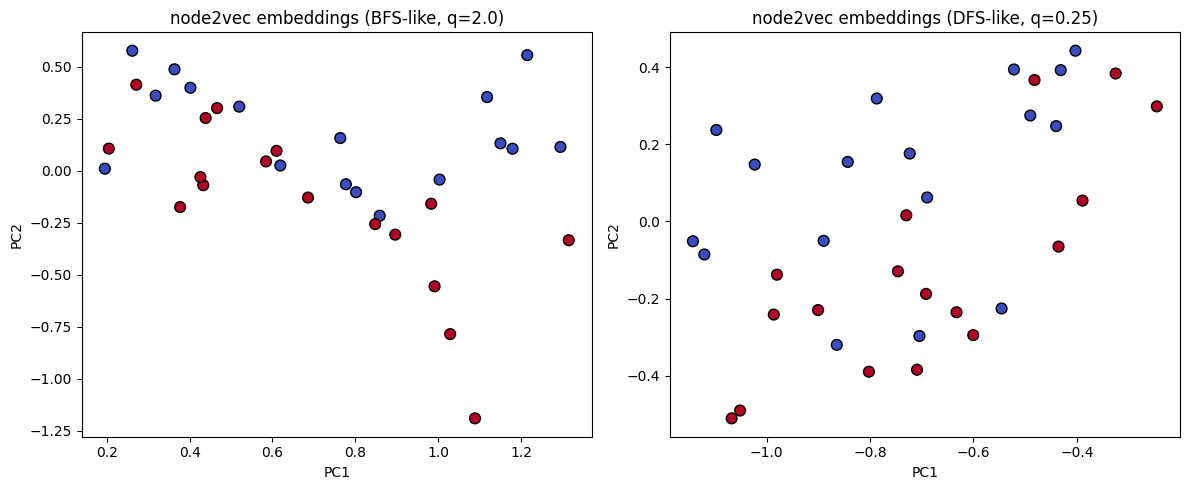

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Left: BFS-like
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(
    emb_bfs_2d[:, 0],
    emb_bfs_2d[:, 1],
    c=club_labels,
    cmap="coolwarm",
    s=60,
    edgecolors="k",
)
plt.title("node2vec embeddings (BFS-like, q=2.0)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Right: DFS-like
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(
    emb_dfs_2d[:, 0],
    emb_dfs_2d[:, 1],
    c=club_labels,
    cmap="coolwarm",
    s=60,
    edgecolors="k",
)
plt.title("node2vec embeddings (DFS-like, q=0.25)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

In [15]:
degrees = np.array([G.degree(n) for n in nodes])

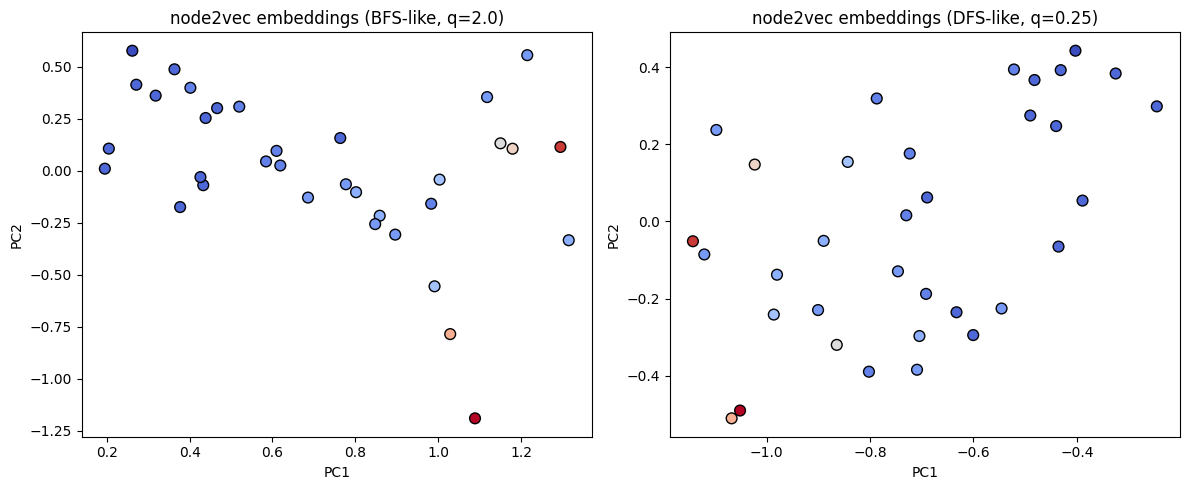

In [16]:
plt.figure(figsize=(12, 5))

# Left: BFS-like
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(
    emb_bfs_2d[:, 0],
    emb_bfs_2d[:, 1],
    c=degrees,
    cmap="coolwarm",
    s=60,
    edgecolors="k",
)
plt.title("node2vec embeddings (BFS-like, q=2.0)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Right: DFS-like
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(
    emb_dfs_2d[:, 0],
    emb_dfs_2d[:, 1],
    c=degrees,
    cmap="coolwarm",
    s=60,
    edgecolors="k",
)
plt.title("node2vec embeddings (DFS-like, q=0.25)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

### How to interpret what you see

* If **colors (communities)** are more clearly separated in one plot, that setting is better at capturing **homophily** in this graph.
* Sometimes BFS-like walks (q>1) highlight **roles** (e.g., hubs vs peripheral), while DFS-like (q<1) highlight **which community** nodes belong to.
  You can play with:

  * Color = community (homophily)
  * Color = degree / betweenness centrality (structural role)